# Install

In [1]:
!pip install segmentation-models-pytorch
!pip install evaluate


# This dataset was downloaded from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !cp -r /content/drive/MyDrive/Jialiang/9517Pro/WildScenes2d/ /content/dataset

# Required packages

In [4]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
# import pytorch_lightning as pl

import torchvision.transforms as transforms
from PIL import Image
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

from PIL import Image
import pandas as pd
from pathlib import Path
import cv2

from sklearn.metrics import confusion_matrix
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from sklearn.metrics import classification_report

# The image preprocess

## The num-class & check the image and marks corretly.

K-03/indexLabel/1639434794-787983411.png

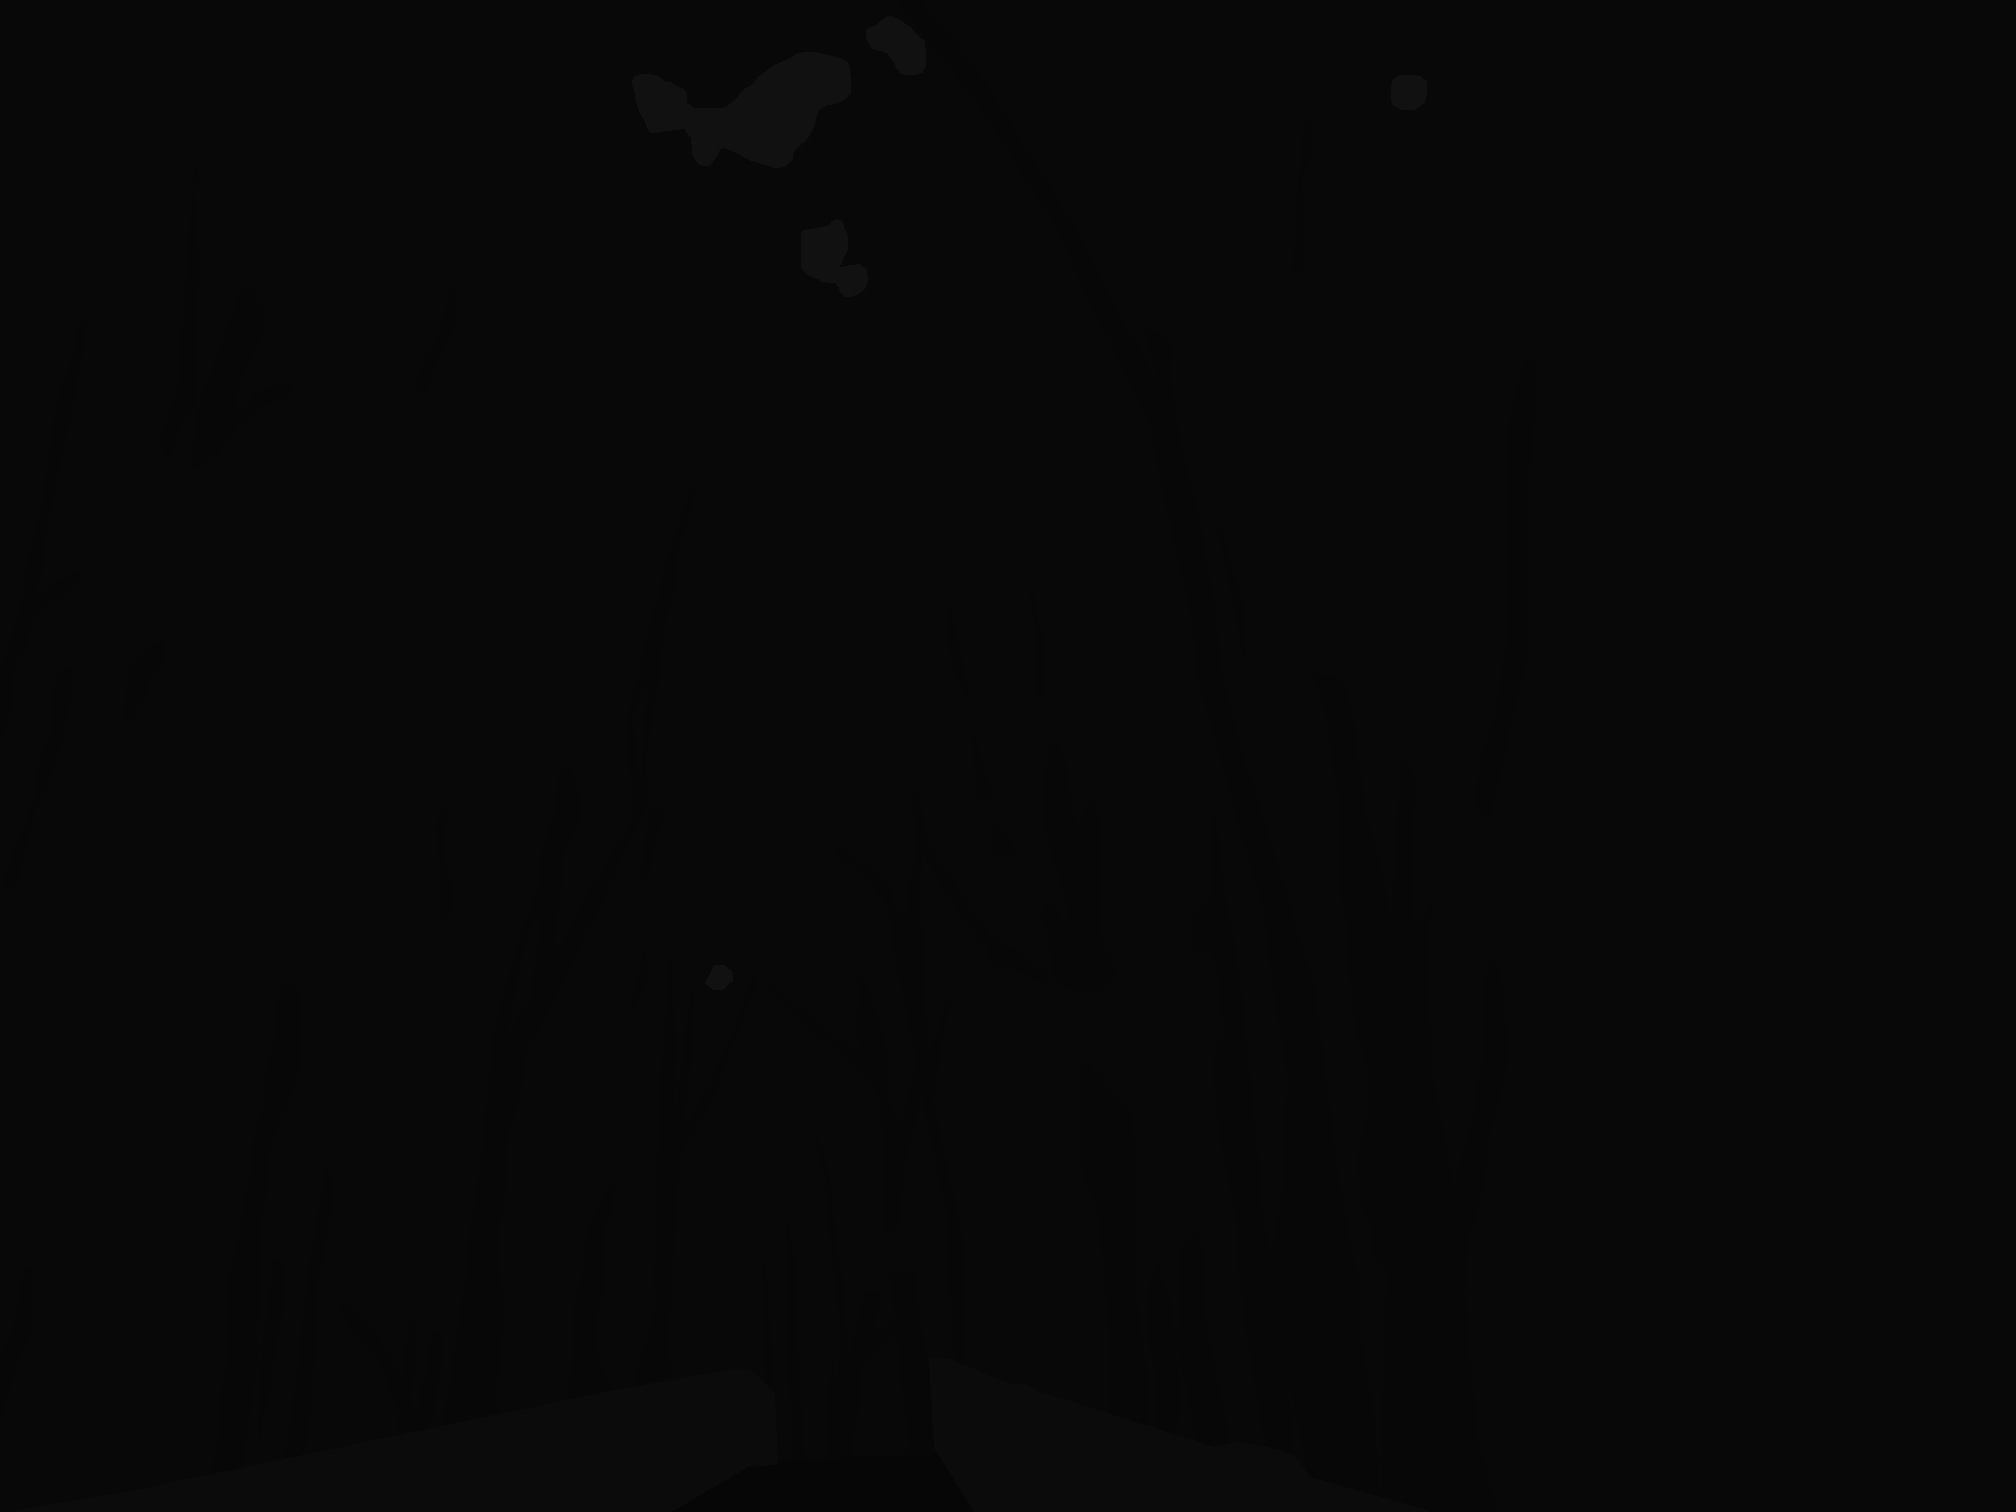

In [5]:
num_classes = 21
# eg_image_path_mask = '/content/dataset/K-01/image/1624325291-972695058.png'
eg_image_path_mask = '/content/dataset/K-03/indexLabel/1639434794-787983411.png'
Image.open(eg_image_path_mask)

In [6]:
one_mask_array = np.array(Image.open(eg_image_path_mask))
np.unique(one_mask_array,return_counts=True)

(array([ 6,  7,  8, 11, 17], dtype=uint8),
 array([  12964,  317642, 2604733,   92291,   20562]))

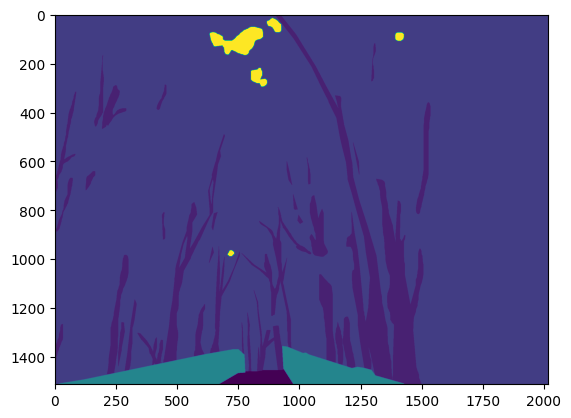

In [7]:
plt.imshow(one_mask_array) # just squeeze classes dim, because we have only one class

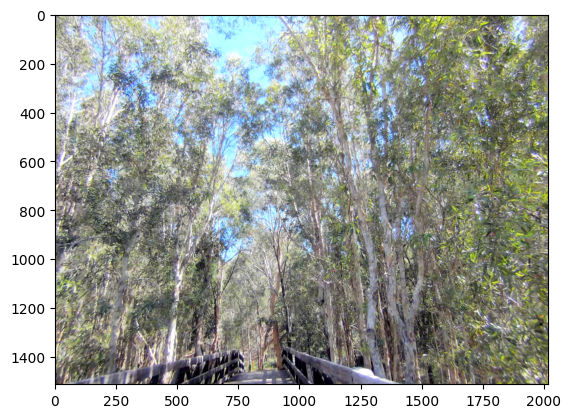

In [8]:
eg_image_path = '/content/dataset/K-03/image/1639434794-787983411.png'
plt.imshow(Image.open(eg_image_path))

## Dataset preparation(sort)

In [ ]:
# !zip -r /content/K-01.zip /content/dataset/K-01

In [9]:
from pathlib import Path
import pandas as pd
image_dir = '/content/dataset/K-03'
p = Path(image_dir)
all_path_list = [str(item) for item in list(p.rglob('*.png'))]
img_path_list = [item for item in all_path_list if item.split('/')[4] == 'image']
mask_path_list = [item for item in all_path_list if item.split('/')[4] == 'indexLabel']
img_path_list.sort()
mask_path_list.sort()

place_name_list = [item.split('/')[3] for item in img_path_list]

img_path_list[:5],mask_path_list[:5], place_name_list[:5]

(['/content/dataset/K-03/image/1639434788-393427181.png',
  '/content/dataset/K-03/image/1639434790-789262725.png',
  '/content/dataset/K-03/image/1639434794-787983411.png',
  '/content/dataset/K-03/image/1639434799-184434074.png',
  '/content/dataset/K-03/image/1639434807-113343018.png'],
 ['/content/dataset/K-03/indexLabel/1639434788-393427181.png',
  '/content/dataset/K-03/indexLabel/1639434790-789262725.png',
  '/content/dataset/K-03/indexLabel/1639434794-787983411.png',
  '/content/dataset/K-03/indexLabel/1639434799-184434074.png',
  '/content/dataset/K-03/indexLabel/1639434807-113343018.png'],
 ['K-03', 'K-03', 'K-03', 'K-03', 'K-03'])

In [10]:
np.array(Image.open(mask_path_list[0]))

array([[ 8,  8,  8, ...,  8,  8,  8],
       [ 8,  8,  8, ...,  8,  8,  8],
       [ 8,  8,  8, ...,  8,  8,  8],
       ...,
       [ 8,  8,  8, ..., 11, 11, 11],
       [ 8,  8,  8, ..., 11, 11, 11],
       [ 8,  8,  8, ..., 11, 11, 11]], dtype=uint8)

In [11]:
data_dict = {'ori_img':img_path_list,"mask_img":mask_path_list}
# data_dict

In [12]:
pd.set_option('display.max_colwidth', 500)
pd_data = pd.DataFrame(data_dict)
pd_data

ori_img  \
0     /content/dataset/K-03/image/1639434788-393427181.png   
1     /content/dataset/K-03/image/1639434790-789262725.png   
2     /content/dataset/K-03/image/1639434794-787983411.png   
3     /content/dataset/K-03/image/1639434799-184434074.png   
4     /content/dataset/K-03/image/1639434807-113343018.png   
...                                                    ...   
3908  /content/dataset/K-03/image/1639442347-849274879.png   
3909  /content/dataset/K-03/image/1639442349-382299006.png   
3910  /content/dataset/K-03/image/1639442351-448623349.png   
3911  /content/dataset/K-03/image/1639442352-581911687.png   
3912  /content/dataset/K-03/image/1639442353-248488731.png   

                                                       mask_img  
0     /content/dataset/K-03/indexLabel/1639434788-393427181.png  
1     /content/dataset/K-03/indexLabel/1639434790-789262725.png  
2     /content/dataset/K-03/indexLabel/1639434794-787983411.png  
3     /content/dataset/K-03/indexLabel/1639434799-184434074.png  
4     /content/dataset/K-03/indexLabel/1639434807-113343018.png  
...                                                         ...  
3908  /content/dataset/K-03/indexLabel/1639442347-849274879.png  
3909  /content/dataset/K-03/indexLabel/1639442349-382299006.png  
3910  /content/dataset/K-03/indexLabel/1639442351-448623349.png  
3911  /content/dataset/K-03/indexLabel/1639442352-581911687.png  
3912  /content/dataset/K-03/indexLabel/1639442353-248488731.png  

[3913 rows x 2 columns]

## My CustomDataset

In [13]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, df_data):

        self.ori_img_path_list = list(df_data['ori_img'])
        self.mask_img_path_list = list(df_data['mask_img'])

    def __len__(self):
        return len(self.ori_img_path_list)

    def __getitem__(self, idx):

        image_path = self.ori_img_path_list[idx]
        mask_path = self.mask_img_path_list[idx]
        # print(mask_path)

        image = np.array(Image.open(image_path).resize((256, 256)).convert("RGB"))
        mask = np.array(Image.open(mask_path).resize((256, 256))).astype('int32')
        # mask = np.where(mask > 127, 1, 0)

        # sample = dict(image=image, mask=mask)

        # convert to other format HWC -> CHW
        image = np.moveaxis(image, -1, 0)
        # mask = np.expand_dims(mask, 0)
        image = torch.tensor(image).float()
        mask = torch.tensor(mask).long()

        return image,mask

## Data Split-4:1

In [43]:
train_dataset = Mydataset(pd_data[ :3130])
test_dataset = Mydataset(pd_data[3130:3913])

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 3130
Test size: 783


# Device Usage

In [15]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# The train function and test function

In [52]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)
            y = y.to(device)
            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n , Avg loss: {test_loss:>8f} \n")
    return test_loss

## DataLoader

In [53]:

n_cpu = os.cpu_count()
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=n_cpu, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=n_cpu, drop_last=True)

## Check  num_classes and shape

In [54]:
for img,mask in train_dl:
  print(img.shape)
  print(mask.shape)
  # print(img.shape,mask.shape)
  print(np.unique(mask,return_counts=True))
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([32, 3, 256, 256])
torch.Size([32, 256, 256])
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), array([      5,    1598,   98582,    1108,    1029,   36975,    1439,
        231982, 1320634,   13709,    5285,    9236,    4937,    5041,
          5460,   12916,    7863,  224098,  113491,    1762,       2]))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [55]:
np.unique(mask,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([      5,    1598,   98582,    1108,    1029,   36975,    1439,
         231982, 1320634,   13709,    5285,    9236,    4937,    5041,
           5460,   12916,    7863,  224098,  113491,    1762,       2]))

## check image input

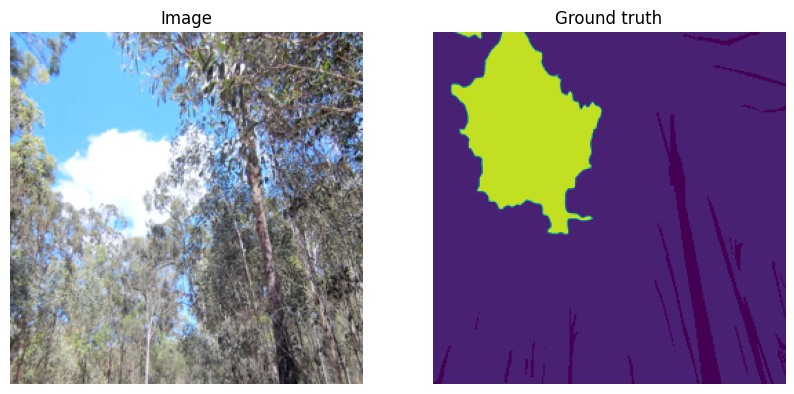

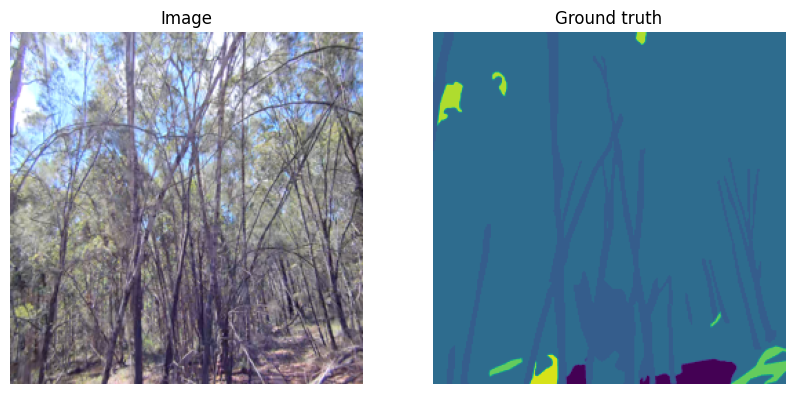

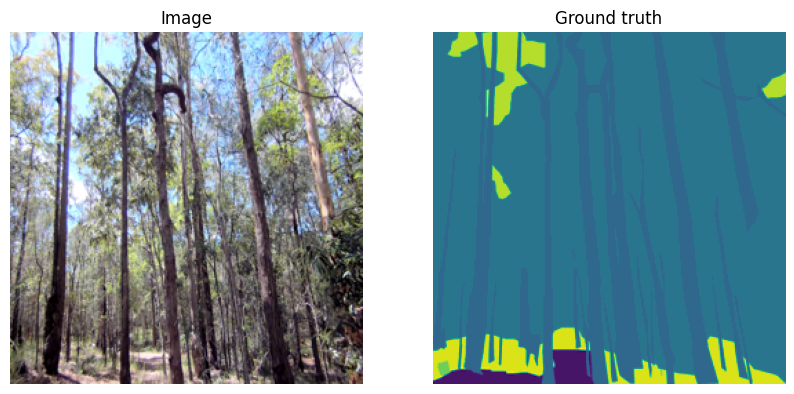

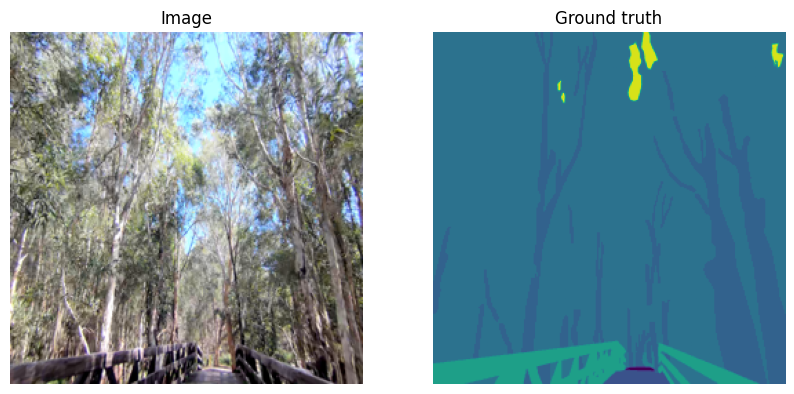

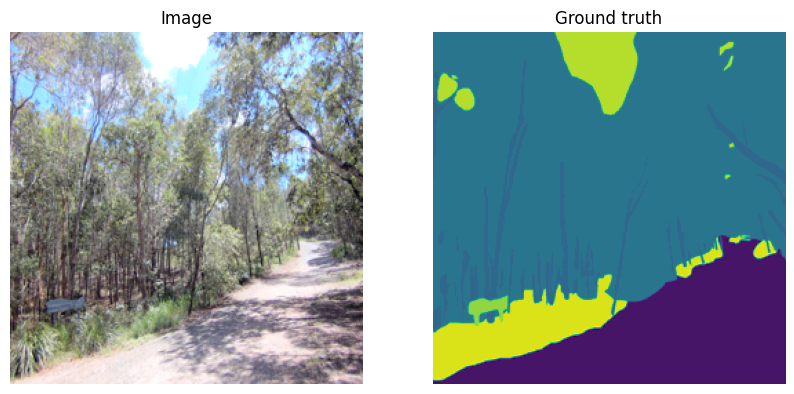

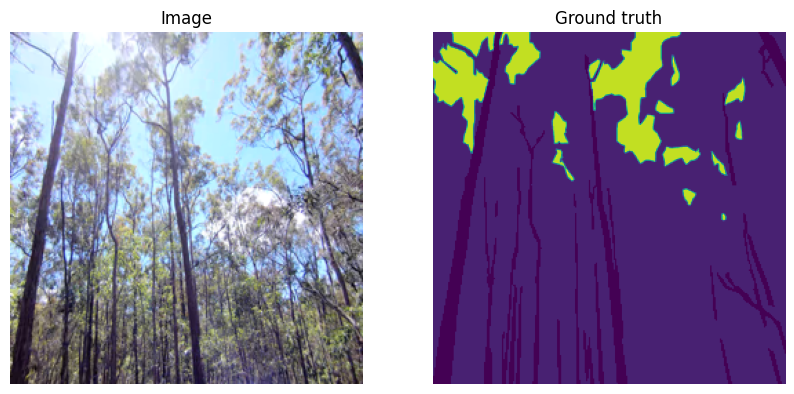

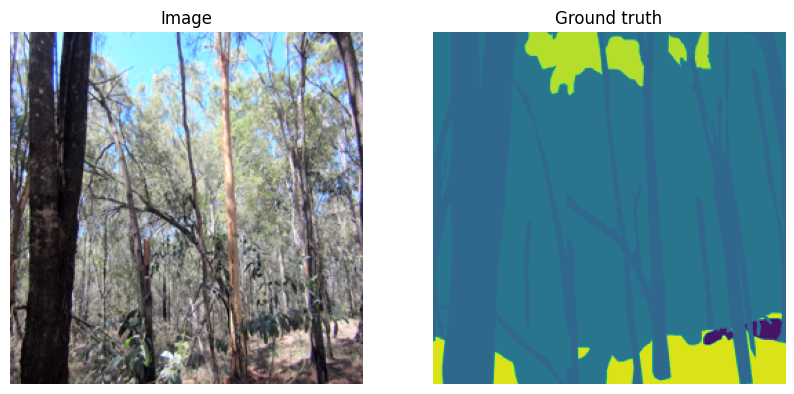

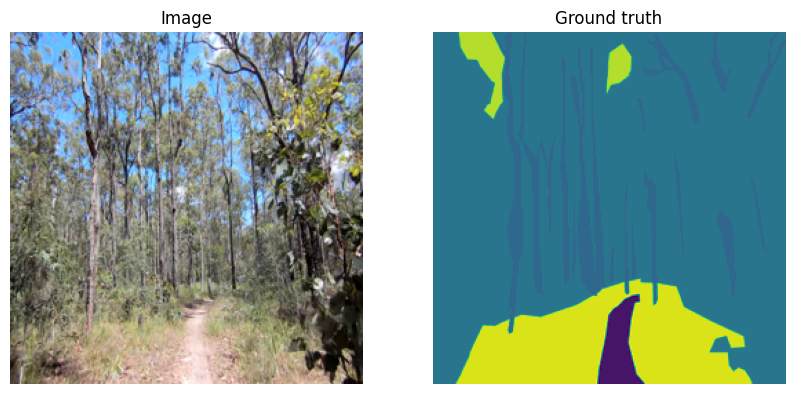

In [20]:
for image, gt_mask in zip(img,mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.long().numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.show()

# Evaluation

In [28]:
import numpy as np
import torch
from sklearn.metrics import classification_report

def calculate_miou1(pred, target, num_classes, ignore_indices=[0,20]):
    pred = pred.view(-1)
    target = target.view(-1)
    miou = []
    for cls in range(num_classes):
        if cls in ignore_indices:
            continue
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            miou.append(1)  # If there is no ground truth, consider it a perfect match
        else:
            miou.append(intersection / union)
    return np.mean(miou) if miou else float('nan')  # Return NaN if all classes are ignored

def get_metrics2(model, test_dl, num_classes=21, ignore_indices=[0,20], merge_indices={4: 4, 5: 4,10:10,11:10,10:10,12:10,10:10,13:10}):
    model.eval()
    label_list = []
    pred_list = []
    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, preds = torch.max(outputs, 1)
            preds_l = preds.cpu().numpy()
            labels_l = labels.cpu().numpy()

            # Map indices for merging classes
            for old_idx, new_idx in merge_indices.items():
                preds_l[preds_l == old_idx] = new_idx
                labels_l[labels_l == old_idx] = new_idx

            label_list.append(labels_l.flatten())
            pred_list.append(preds_l.flatten())

    # Concatenate all predictions and labels
    label_array = np.concatenate(label_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    # Filter out ignore indices from classification report
    valid_indices = np.isin(label_array, ignore_indices, invert=True)
    label_array_filtered = label_array[valid_indices]
    pred_array_filtered = pred_array[valid_indices]

    classify_result = classification_report(label_array_filtered, pred_array_filtered, digits=3)
    print(classify_result)

    # Compute IoU ignoring specified indices
    iou_result = calculate_miou1(torch.tensor(pred_array), torch.tensor(label_array), num_classes, ignore_indices)
    print(f"Mean IoU (ignoring indices {ignore_indices}): {iou_result}")

    return classify_result, iou_result



# DeepLabV3(Resnet34)

## Pre-trained Model

In [70]:
# import segmentation_models_pytorch as smp

model = smp.DeepLabV3(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=num_classes,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 53.0MB/s]


In [71]:
model = model.to(device)
mask.shape
model(img.to(device)).shape

torch.Size([32, 21, 256, 256])

## Train loop

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5
train_loss_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    train_loss = test(train_dl, model, loss_fn)
    test_loss = test(test_dl, model, loss_fn)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


loss: 3.181993  [   32/ 3130]
loss: 1.196063  [  352/ 3130]
loss: 0.872279  [  672/ 3130]
loss: 0.788055  [  992/ 3130]
loss: 0.688064  [ 1312/ 3130]
loss: 0.705315  [ 1632/ 3130]
loss: 0.682835  [ 1952/ 3130]
loss: 0.673600  [ 2272/ 3130]
loss: 0.616255  [ 2592/ 3130]
loss: 0.613735  [ 2912/ 3130]
Test Error: 
 , Avg loss: 0.580021 

Test Error: 
 , Avg loss: 0.797336 

Epoch 2
-------------------------------
loss: 0.610763  [   32/ 3130]
loss: 0.558760  [  352/ 3130]
loss: 0.546602  [  672/ 3130]
loss: 0.506579  [  992/ 3130]
loss: 0.522692  [ 1312/ 3130]
loss: 0.598530  [ 1632/ 3130]
loss: 0.572786  [ 1952/ 3130]
loss: 0.576365  [ 2272/ 3130]
loss: 0.561290  [ 2592/ 3130]
loss: 0.530705  [ 2912/ 3130]
Test Error: 
 , Avg loss: 0.525499 

Test Error: 
 , Avg loss: 0.791566 

Epoch 3
-------------------------------
loss: 0.506053  [   32/ 3130]
loss: 0.527256  [  352/ 3130]
loss: 0.520478  [  672/ 3130]
loss: 0.538835  [  992/ 3130]
loss: 0.514220  [ 1312/ 3130]
loss: 0.548529  [ 1632

## Loss Curve Visualization

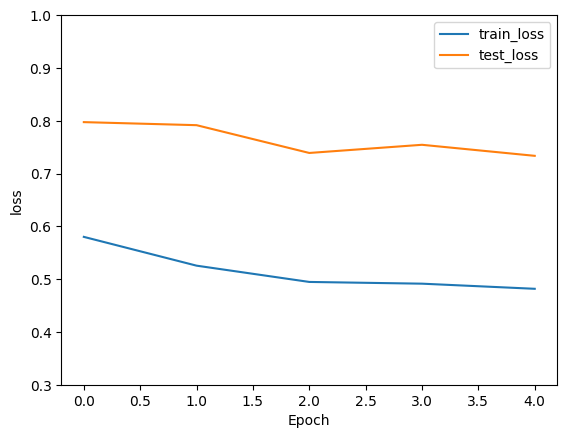

In [78]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.3, 1])
# plt.xlim([0, 5])
plt.legend(loc='upper right')


## Evaluation matric & mIoU

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
classify_result2, iou_result2 = get_metrics2(model, test_dl, num_classes=21, ignore_indices=[0,20], merge_indices={ 4: 4, 5: 4,10:10,11:10,10:10,12:10,10:10,13:10})

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined a

              precision    recall  f1-score   support

           1      0.000     0.000     0.000     75251
           2      0.790     0.683     0.733   7774130
           3      0.000     0.000     0.000    359184
           4      0.000     0.000     0.000    408097
           6      0.000     0.000     0.000    145265
           7      0.661     0.542     0.596   8501308
           8      0.842     0.919     0.878  24941269
           9      0.363     0.122     0.182    381512
          10      0.046     0.000     0.000    380434
          14      0.000     0.000     0.000    109891
          15      0.425     0.010     0.019    391519
          16      0.811     0.033     0.064    144197
          17      0.833     0.383     0.525    441209
          18      0.551     0.787     0.648   6718685
          19      0.000     0.000     0.000     83657

    accuracy                          0.754  50855608
   macro avg      0.355     0.232     0.243  50855608
weighted avg      0.733   

## Results Visualization & comparison

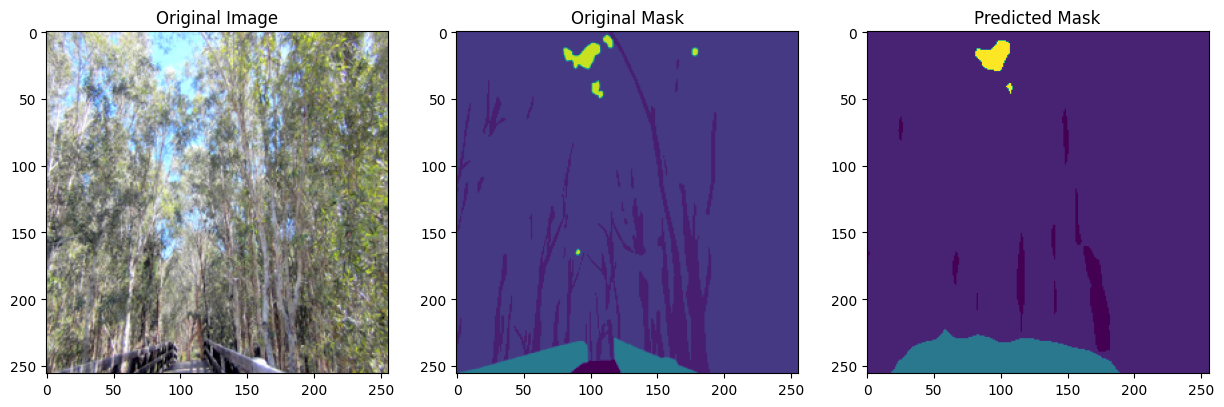

In [81]:
def plot_comparison(original_img, original_mask, predicted_mask):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[1].imshow(original_mask)
    axs[1].set_title('Original Mask')
    axs[2].imshow(predicted_mask)
    axs[2].set_title('Predicted Mask')
    plt.show()


image_path = '/content/dataset/K-03/image/1639434794-787983411.png'
mask_path = '/content/dataset/K-03/indexLabel/1639434794-787983411.png'

image = np.array(Image.open(image_path).resize((256, 256)).convert("RGB"))
mask = np.array(Image.open(mask_path).resize((256, 256))).astype('int32')


image = np.moveaxis(image, -1, 0)
image = torch.tensor(image).float().unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    pred = model(image)
    pred = torch.argmax(pred, dim=1).squeeze().cpu().numpy()


image_for_plot = np.moveaxis(image.squeeze().cpu().numpy(), 0, -1).astype('uint8')


plot_comparison(image_for_plot, mask, pred)